In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd

import plotly.express as px
from pmdarima import auto_arima

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

from shapely.geometry import Point
import contextily as ctx

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [2]:
df_renewable_power_plants = pd.read_csv("renewable_power_plants_DE_filtered_2019.csv")
df_renewable_power_plants.columns

/tmp/ipykernel_5935/279531070.py:1: DtypeWarning: Columns (14,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df_renewable_power_plants = pd.read_csv("renewable_power_plants_DE_filtered_2019.csv")


Index(['electrical_capacity', 'energy_source_level_1', 'energy_source_level_2',
       'energy_source_level_3', 'technology', 'data_source', 'nuts_1_region',
       'nuts_2_region', 'nuts_3_region', 'lon', 'lat', 'municipality',
       'municipality_code', 'postcode', 'address', 'federal_state',
       'commissioning_date', 'decommissioning_date', 'voltage_level', 'eeg_id',
       'dso', 'dso_id', 'tso'],
      dtype='object')

In [30]:
num_rows_berlin = df_renewable_power_plants[df_renewable_power_plants["federal_state"] == "Berlin"].shape[0]
print(f"Number of rows where federal_state is 'Berlin': {num_rows_berlin}")


Number of rows where federal_state is 'Berlin': 35


In [29]:
df_renewable_power_plants.tail()

electrical_capacity energy_source_level_1 energy_source_level_2  \
92574             0.009920      Renewable energy                 Solar   
92575             0.009750      Renewable energy                 Solar   
92576             0.006500      Renewable energy                 Solar   
92577             0.009800      Renewable energy                 Solar   
92578             0.009975      Renewable energy                 Solar   

      energy_source_level_3     technology data_source nuts_1_region  \
92574                   NaN  Photovoltaics  TransnetBW           DE1   
92575                   NaN  Photovoltaics      TenneT           DE2   
92576                   NaN  Photovoltaics      TenneT           DE7   
92577                   NaN  Photovoltaics      TenneT           DE7   
92578                   NaN  Photovoltaics  TransnetBW           DE1   

      nuts_2_region nuts_3_region        lon  ...  postcode address  \
92574          DE11         DE11D  10.113042  ...   73433.0     NaN   
92575          DE26         DE26C  10.019952  ...   97230.0     NaN   
92576          DE73         DE736   9.109868  ...   34471.0     NaN   
92577          DE71         DE719   9.382804  ...   63628.0     NaN   
92578          DE13         DE134   7.943583  ...   77960.0     NaN   

           federal_state  commissioning_date decommissioning_date  \
92574  Baden-Württemberg          2019-12-31                  NaN   
92575        Brandenburg          2019-12-31                  NaN   
92576            Hamburg          2019-12-31                  NaN   
92577            Hamburg          2019-12-31                  NaN   
92578  Baden-Württemberg          2019-12-31                  NaN   

      voltage_level eeg_id                                     dso  \
92574   low voltage    NaN                   Stadtwerke Aalen GmbH   
92575   low voltage    NaN                  Mainfranken Netze GmbH   
92576   low voltage    NaN        Energie Waldeck-Frankenberg GmbH   
92577   low voltage    NaN                      OsthessenNetz GmbH   
92578   low voltage    NaN  Überlandwerk Mittelbaden GmbH & Co. KG   

           dso_id         tso  
92574  10001635.0  TransnetBW  
92575  10003071.0      TenneT  
92576  10000523.0      TenneT  
92577  10001747.0      TenneT  
92578  10001904.0  TransnetBW  

[5 rows x 23 columns]

In [118]:
df_renewable_power_plants.columns

Index(['electrical_capacity', 'energy_source_level_1', 'energy_source_level_2',
       'energy_source_level_3', 'technology', 'data_source', 'nuts_1_region',
       'nuts_2_region', 'nuts_3_region', 'lon', 'lat', 'municipality',
       'municipality_code', 'postcode', 'address', 'federal_state',
       'commissioning_date', 'decommissioning_date', 'voltage_level', 'eeg_id',
       'dso', 'dso_id', 'tso'],
      dtype='object')

In [119]:
df_renewable_power_plants.dtypes

electrical_capacity      float64
energy_source_level_1     object
energy_source_level_2     object
energy_source_level_3     object
technology                object
data_source               object
nuts_1_region             object
nuts_2_region             object
nuts_3_region             object
lon                      float64
lat                      float64
municipality              object
municipality_code        float64
postcode                 float64
address                   object
federal_state             object
commissioning_date        object
decommissioning_date     float64
voltage_level             object
eeg_id                    object
dso                       object
dso_id                   float64
tso                       object
dtype: object

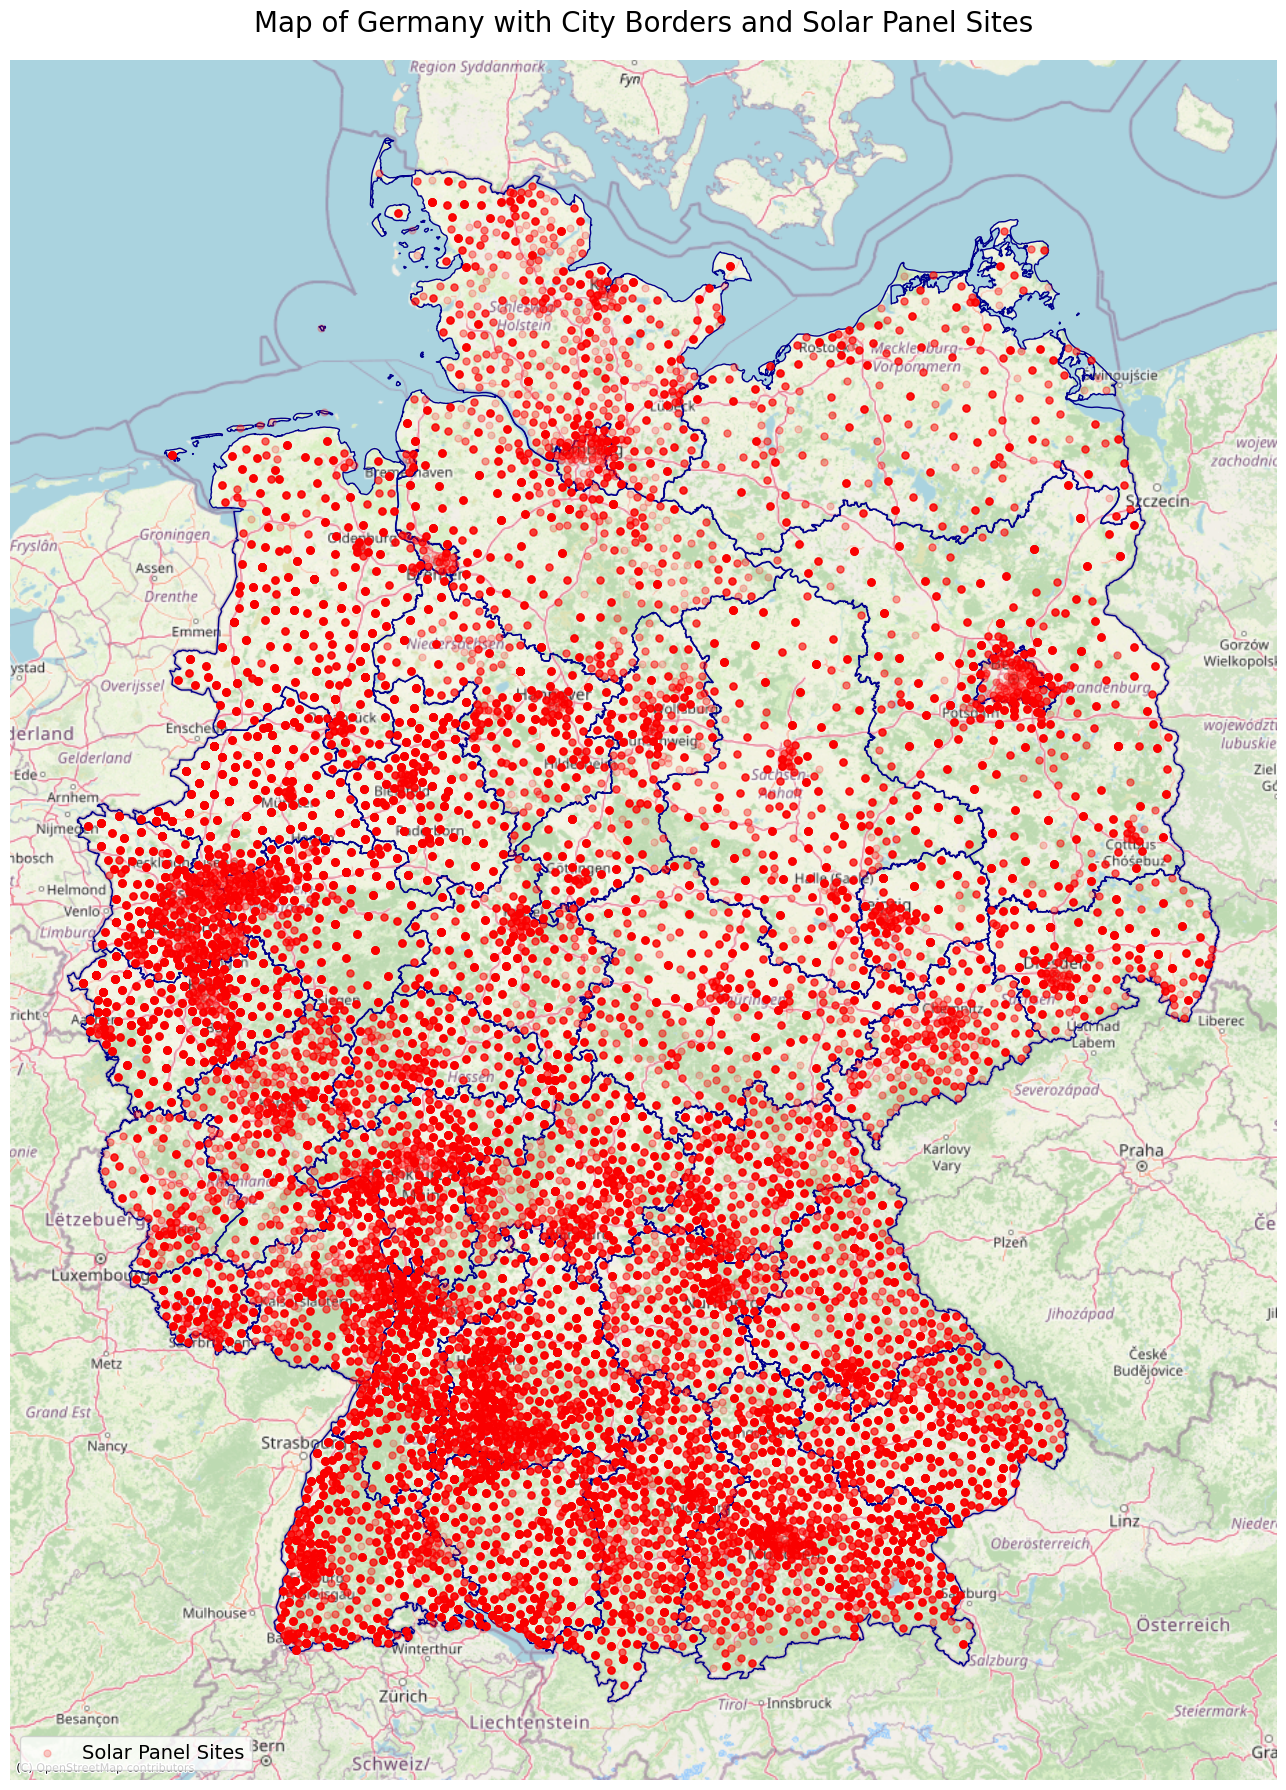

In [34]:
# Step 1: Load the world shapefile (Germany ADM3)
path_to_country_shapefile = "geoBoundaries-DEU-ADM3-all/geoBoundaries-DEU-ADM3.shp"
world = gpd.read_file(path_to_country_shapefile)


# Filter for Germany using the shapeName column
germany = world[world['shapeName'] == 'Germany']

# Step 2: Load city/district boundaries (ADM2)
path_to_cities_shapefile = "geoBoundaries-DEU-ADM2-all/geoBoundaries-DEU-ADM2.shp"
cities = gpd.read_file(path_to_cities_shapefile)

# Ensure CRS matches
cities = cities.to_crs(germany.crs)

# Step 3: Load the solar panel dataset
solar_geometry = [Point(xy) for xy in zip(df_renewable_power_plants['lon'], df_renewable_power_plants['lat'])]
solar_geo_data = gpd.GeoDataFrame(df_renewable_power_plants, geometry=solar_geometry, crs="EPSG:4326")
solar_geo_data = solar_geo_data.to_crs(epsg=3857)  # Convert to Web Mercator

# Convert Germany and city boundaries to the same CRS
germany = germany.to_crs(epsg=3857)
cities = cities.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(16, 18))

# Plot Germany boundary (no legend)
if not germany.empty:
    germany.plot(ax=ax, color='whitesmoke', edgecolor='black', linewidth=2.5, alpha=0.6)

# Plot city/district boundaries (no legend)
if not cities.empty:
    cities.plot(ax=ax, color='none', edgecolor='darkblue', linewidth=1)

# Plot solar panel locations (only this has a legend)
if not solar_geo_data.empty:
    solar_geo_data.plot(ax=ax, color='red', alpha=0.2, markersize=25, label='Solar Panel Sites')

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Title
plt.title("Map of Germany with City Borders and Solar Panel Sites", fontsize=20, pad=20)

# Keep only the legend for solar panel sites
plt.legend(["Solar Panel Sites"], loc='lower left', fontsize=14)

# Hide axis
ax.set_axis_off()
plt.tight_layout()

# Show plot
plt.show()

(1940184, 3)
(515, 2)


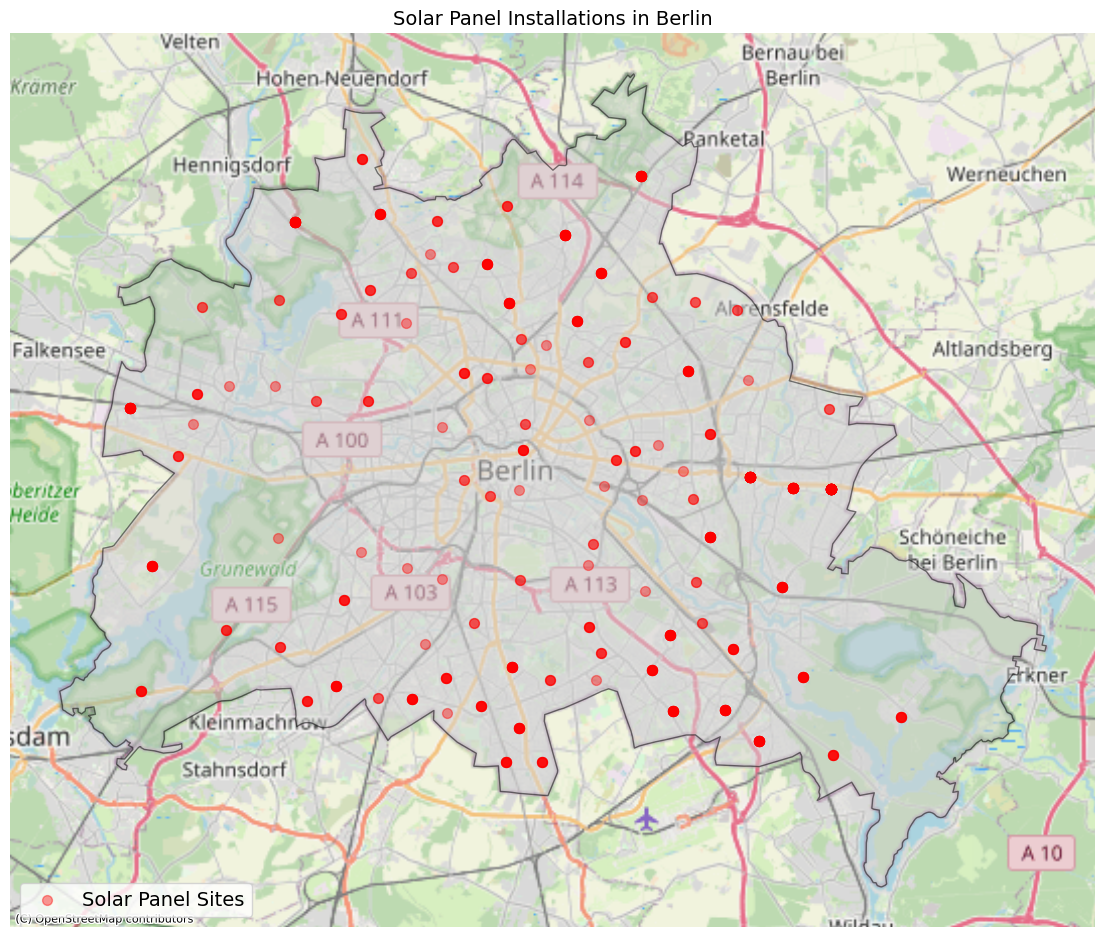

In [31]:
# Load only the necessary columns from the dataset
columns_to_use = ["lon", "lat", "federal_state"]

# Load the dataset
df = pd.read_csv("renewable_power_plants_DE_filtered_all.csv", usecols=columns_to_use)

print(df.shape)

# Filter for Berlin data
df_berlin = df[df["federal_state"] == "Berlin"][["lon", "lat"]]

# Define Berlin's approximate coordinate range
min_lon, max_lon = 13.0, 13.7  # Typical Berlin longitude range
min_lat, max_lat = 52.3, 52.7  # Typical Berlin latitude range

# Find outliers
outliers = df_berlin[(df_berlin["lon"] < min_lon) | (df_berlin["lon"] > max_lon) |
                      (df_berlin["lat"] < min_lat) | (df_berlin["lat"] > max_lat)]

df_berlin = df_berlin.drop(outliers.index)

print(df_berlin.shape)

# Convert to GeoDataFrame
gdf_berlin = gpd.GeoDataFrame(df_berlin, 
                              geometry=gpd.points_from_xy(df_berlin["lon"], df_berlin["lat"]),
                              crs="EPSG:4326")  # WGS 84 coordinate system

# Load the shapefile (Replace with your actual file path)
germany_admin = gpd.read_file("geoBoundaries-DEU-ADM1-all/geoBoundaries-DEU-ADM1.shp")

# Filter for Berlin (adjust column name based on output)
berlin_boundary = germany_admin[germany_admin["shapeName"] == "Berlin"]  # Change "NAME_COLUMN" to the actual column

# Convert Berlin boundary to match the CRS of our dataset
berlin_boundary = berlin_boundary.to_crs(epsg=3857)  
gdf_berlin = gdf_berlin.to_crs(epsg=3857)  

# Plot Berlin boundary and solar panel locations
fig, ax = plt.subplots(figsize=(14, 12))
berlin_boundary.plot(ax=ax, edgecolor="black", facecolor="lightgray", alpha=0.5, linewidth=1)
gdf_berlin.plot(ax=ax, color="red", markersize=50, alpha=0.4, label="Solar Panels")

# Add a basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Customize plot
ax.set_title("Solar Panel Installations in Berlin", fontsize=14)
ax.axis("off")
plt.legend(["Solar Panel Sites"], loc='lower left', fontsize=14)

# Show the plot
plt.show()

In [26]:
df_time_series = pd.read_csv("time_series_60min_singleindex_filtered.csv")

In [5]:
df_time_series.head()

utc_timestamp        cet_cest_timestamp  \
0  2014-12-31T23:00:00Z  2015-01-01T00:00:00+0100   
1  2015-01-01T00:00:00Z  2015-01-01T01:00:00+0100   
2  2015-01-01T01:00:00Z  2015-01-01T02:00:00+0100   
3  2015-01-01T02:00:00Z  2015-01-01T03:00:00+0100   
4  2015-01-01T03:00:00Z  2015-01-01T04:00:00+0100   

   DE_load_actual_entsoe_transparency  DE_load_forecast_entsoe_transparency  \
0                                 NaN                                   NaN   
1                             41151.0                               39723.0   
2                             40135.0                               38813.0   
3                             39106.0                               38490.0   
4                             38765.0                               38644.0   

   DE_solar_capacity  DE_solar_generation_actual  DE_solar_profile  \
0            37248.0                         NaN               NaN   
1            37248.0                         NaN               NaN   
2            37248.0                         NaN               NaN   
3            37248.0                         NaN               NaN   
4            37248.0                         NaN               NaN   

   DE_wind_capacity  DE_wind_generation_actual  DE_wind_profile  \
0           27913.0                        NaN              NaN   
1           27913.0                     8852.0           0.3171   
2           27913.0                     9054.0           0.3244   
3           27913.0                     9070.0           0.3249   
4           27913.0                     9163.0           0.3283   

   DE_wind_offshore_capacity  DE_wind_offshore_generation_actual  \
0                      667.0                                 NaN   
1                      667.0                               517.0   
2                      667.0                               514.0   
3                      667.0                               518.0   
4                      667.0                               520.0   

   DE_wind_offshore_profile  DE_wind_onshore_capacity  \
0                       NaN                   27246.0   
1                    0.7744                   27246.0   
2                    0.7710                   27246.0   
3                    0.7761                   27246.0   
4                    0.7793                   27246.0   

   DE_wind_onshore_generation_actual  DE_wind_onshore_profile  
0                                NaN                      NaN  
1                             8336.0                   0.3059  
2                             8540.0                   0.3134  
3                             8552.0                   0.3139  
4                             8643.0                   0.3172

In [125]:
df_time_series.columns

Index(['utc_timestamp', 'cet_cest_timestamp',
       'DE_load_actual_entsoe_transparency',
       'DE_load_forecast_entsoe_transparency', 'DE_solar_capacity',
       'DE_solar_generation_actual', 'DE_solar_profile', 'DE_wind_capacity',
       'DE_wind_generation_actual', 'DE_wind_profile',
       'DE_wind_offshore_capacity', 'DE_wind_offshore_generation_actual',
       'DE_wind_offshore_profile', 'DE_wind_onshore_capacity',
       'DE_wind_onshore_generation_actual', 'DE_wind_onshore_profile'],
      dtype='object')

In [126]:
df_time_series.dtypes

utc_timestamp                            object
cet_cest_timestamp                       object
DE_load_actual_entsoe_transparency      float64
DE_load_forecast_entsoe_transparency    float64
DE_solar_capacity                       float64
DE_solar_generation_actual              float64
DE_solar_profile                        float64
DE_wind_capacity                        float64
DE_wind_generation_actual               float64
DE_wind_profile                         float64
DE_wind_offshore_capacity               float64
DE_wind_offshore_generation_actual      float64
DE_wind_offshore_profile                float64
DE_wind_onshore_capacity                float64
DE_wind_onshore_generation_actual       float64
DE_wind_onshore_profile                 float64
dtype: object

In [100]:
# Convert timestamp columns to datetime
df_time_series['utc_timestamp'] = pd.to_datetime(df_time_series['utc_timestamp'], errors='coerce')
if 'cet_cest_timestamp' in df_time_series.columns:
    df_time_series['cet_cest_timestamp'] = pd.to_datetime(df_time_series['cet_cest_timestamp'], errors='coerce')

# Display the first few rows of the dataset to confirm successful loading and parsing
df_time_series.head()

KeyError: 'utc_timestamp'

In [6]:
# Check for missing values in the dataset
missing_summary = df_time_series.isnull().sum()

# Display columns with missing values and their counts
missing_summary = missing_summary[missing_summary > 0]

# Display the summary to the user
missing_summary

DE_load_actual_entsoe_transparency         1
DE_load_forecast_entsoe_transparency      25
DE_solar_capacity                       6601
DE_solar_generation_actual               104
DE_solar_profile                        6705
DE_wind_capacity                        6601
DE_wind_generation_actual                 75
DE_wind_profile                         6676
DE_wind_offshore_capacity               6601
DE_wind_offshore_generation_actual        75
DE_wind_offshore_profile                6676
DE_wind_onshore_capacity                6601
DE_wind_onshore_generation_actual         73
DE_wind_onshore_profile                 6674
dtype: int64

In [7]:
# Handle missing values:
# For continuous data (load and energy generation), use forward-fill for imputation
df_time_series.fillna(method='ffill', inplace=True)

# For columns with significant missing data, impute with median values
columns_with_large_missing = [
    'DE_solar_capacity', 'DE_solar_profile', 'DE_wind_capacity',
    'DE_wind_profile', 'DE_wind_offshore_capacity', 'DE_wind_offshore_profile',
    'DE_wind_onshore_capacity', 'DE_wind_onshore_profile'
]
for col in columns_with_large_missing:
    if col in df_time_series.columns:
        df_time_series[col].fillna(df_time_series[col].median(), inplace=True)

# Verify missing values are resolved
missing_summary_after = df_time_series.isnull().sum()

# Display columns that still have missing values (if any)
missing_summary_after = missing_summary_after[missing_summary_after > 0]
missing_summary_after

/tmp/ipykernel_56738/1282072756.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_time_series.fillna(method='ffill', inplace=True)
/tmp/ipykernel_56738/1282072756.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_time_series[col].fillna(df_time_series[col].median(), inplace=True)
/tmp/ipykernel_56738/1282072756.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment usin

DE_load_actual_entsoe_transparency      1
DE_load_forecast_entsoe_transparency    1
DE_solar_generation_actual              8
DE_wind_generation_actual               1
DE_wind_offshore_generation_actual      1
DE_wind_onshore_generation_actual       1
dtype: int64

In [8]:
# Handle the remaining missing values using backward-fill
df_time_series.fillna(method='bfill', inplace=True)

# Verify again to ensure no missing values remain
missing_summary_final = df_time_series.isnull().sum()

# Display if any columns still have missing values
missing_summary_final = missing_summary_final[missing_summary_final > 0]
missing_summary_final

/tmp/ipykernel_56738/2053278426.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_time_series.fillna(method='bfill', inplace=True)


Series([], dtype: int64)

XGBoost RMSE: 1744.69


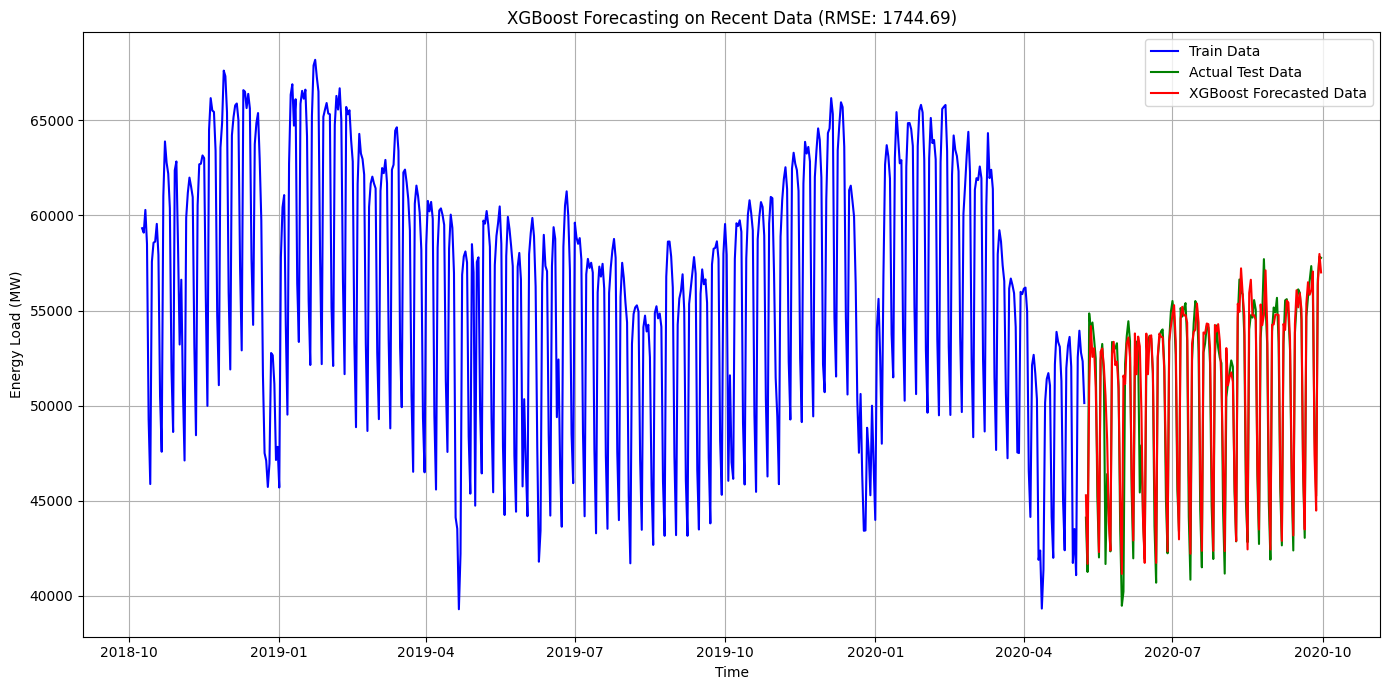

In [135]:
# Load dataset
df_time_series = pd.read_csv('time_series_60min_singleindex_filtered.csv')

target_column = 'DE_load_actual_entsoe_transparency'

if 'utc_timestamp' in df_time_series.columns:
    df_time_series['utc_timestamp'] = pd.to_datetime(df_time_series['utc_timestamp'])
    df_time_series.set_index('utc_timestamp', inplace=True)

# Downsample to daily averages
df_daily = df_time_series[target_column].resample('D').mean()

df_recent = df_daily[-730:]  # Last 2 years

# Feature engineering
df_recent = df_recent.to_frame()
df_recent['day_of_week'] = df_recent.index.dayofweek
df_recent['month'] = df_recent.index.month
df_recent['lag_1'] = df_recent[target_column].shift(1)
df_recent['lag_7'] = df_recent[target_column].shift(7)
df_recent.dropna(inplace=True)

# Train-test split
split_index_recent = int(len(df_recent) * 0.8)
train_data_recent = df_recent.iloc[:split_index_recent]
test_data_recent = df_recent.iloc[split_index_recent:]

X_train = train_data_recent.drop(columns=[target_column])
y_train = train_data_recent[target_column]
X_test = test_data_recent.drop(columns=[target_column])
y_test = test_data_recent[target_column]

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train XGBoost model
model_xgb = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
model_xgb.fit(X_train_scaled, y_train)

# Forecasting
y_pred_xgb = model_xgb.predict(X_test_scaled)

# Evaluate XGBoost RMSE
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
print(f'XGBoost RMSE: {rmse_xgb:.2f}')

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(train_data_recent.index, y_train, label='Train Data', color='blue')
plt.plot(test_data_recent.index, y_test, label='Actual Test Data', color='green')
plt.plot(test_data_recent.index, y_pred_xgb, label='XGBoost Forecasted Data', color='red')
plt.title(f'XGBoost Forecasting on Recent Data (RMSE: {rmse_xgb:.2f})')
plt.xlabel('Time')
plt.ylabel('Energy Load (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
df_solar_pv_price = pd.read_csv("solar-pv-prices-vs-cumulative-capacity/solar-pv-prices-vs-cumulative-capacity.csv")
df_solar_pv_price.head()

print(df_solar_pv_price.columns)
print(df_solar_pv_price.dtypes)

Index(['Entity', 'Code', 'Year', 'Solar photovoltaic module price',
       'Solar photovoltaic cumulative capacity'],
      dtype='object')
Entity                                     object
Code                                       object
Year                                        int64
Solar photovoltaic module price           float64
Solar photovoltaic cumulative capacity    float64
dtype: object


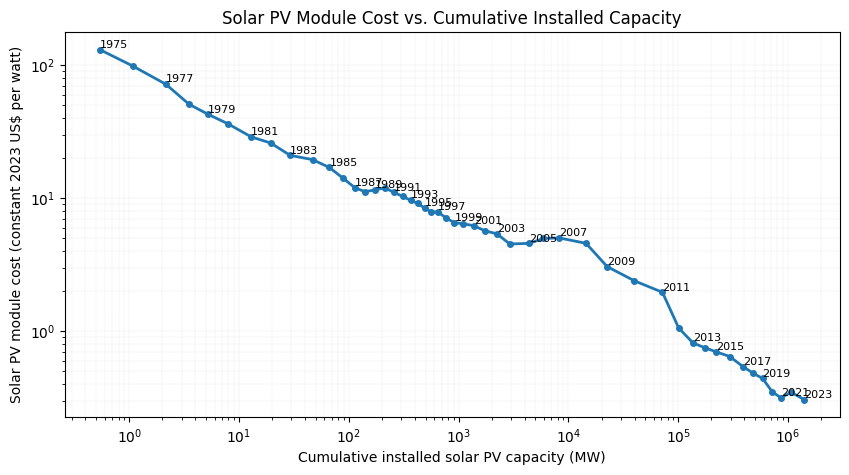

In [26]:
# Extract relevant data
years = df_solar_pv_price["Year"]
prices = df_solar_pv_price["Solar photovoltaic module price"]
capacity = df_solar_pv_price["Solar photovoltaic cumulative capacity"]

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(capacity, prices, marker='o', linestyle='-', linewidth=2, markersize=4)

# Annotate with years
for i in range(0, len(years), 2):  # Annotate every 2nd year for clarity
    plt.text(capacity[i], prices[i], str(years[i]), fontsize=8, verticalalignment='bottom')

# Set log scales
plt.xscale("log")
plt.yscale("log")

# Labels and title
plt.xlabel("Cumulative installed solar PV capacity (MW)")
plt.ylabel("Solar PV module cost (constant 2023 US$ per watt)")
plt.title("Solar PV Module Cost vs. Cumulative Installed Capacity")

# Grid and layout
plt.grid(True, which="both", linestyle="--", linewidth=0.1)
plt.show()